In [1]:
import time
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import osmnx as ox
from shapely.geometry import Point, Polygon

ox.config(use_cache=True, log_console=True)
%matplotlib inline

## Configure the script

In [2]:
places = {'oakland_telegraph' : (37.823769, -122.266000),
          'florence_duomo' : (43.772912, 11.255328),
          'tokyo_takaracho' : (35.675906, 139.772289)}

distances = [500] #804.67 meters in each direction makes for 1 square mile, 500 meters is 1 sq km

## Define functions

In [3]:
def get_graph(coords, distance):
    
    G = ox.graph_from_point(center_point=coords, distance=distance, distance_type='bbox', network_type='all',
                            simplify=True, truncate_by_edge=True)
    
    return G

In [4]:
def calculate_planar_intersections(coords, distance):
    
    buffer = 500
    G = get_graph(coords, distance + buffer)
    
    # get an undirected graph to do line intersection counts (so we don't have identical line segments in each direction)
    G_undir = ox.get_undirected(G)
    gdf_edges = ox.graph_to_gdfs(G_undir, nodes=False)
    
    # trim the lines to the bounding box
    north, south, east, west = ox.bbox_from_point(coords, distance)
    bbox = Polygon([(west, north), (west, south), (east, south), (east, north)])
    lines_in_bbox = gdf_edges.intersection(bbox)
    lines_in_bbox = lines_in_bbox[~lines_in_bbox.is_empty]
    
    # find all points where lines intersect
    all_intersect_points = []
    lines = lines_in_bbox
    for label, line in lines.iteritems():
        intersect_points = lines.drop(label).intersection(line) #intersect with everything but itself
        mask = intersect_points.map(lambda x: isinstance(x, Point))
        all_intersect_points.extend(intersect_points[mask].tolist())
        
    # de-dupe the points of intersection
    all_intersect_points = gpd.GeoSeries(all_intersect_points)
    planar_intersections = gpd.GeoSeries(list(all_intersect_points.unary_union))
    
    return planar_intersections

In [5]:
def calculate_planar_intersections_old(G):
    
    # get an undirected graph to do line intersection counts (so we don't have identical line segments in each direction)
    G_undir = ox.get_undirected(G)
    gdf_edges = ox.graph_to_gdfs(G_undir, nodes=False)
    
    all_intersect_points = []
    lines = gdf_edges['geometry']
    for label, line in lines.iteritems():
        intersect_points = lines.drop(label).intersection(line) #intersect with everything but itself
        mask = intersect_points.map(lambda x: isinstance(x, Point))
        all_intersect_points.extend(intersect_points[mask].tolist())
        
    # how many planar line intersections are there?
    all_intersect_points = gpd.GeoSeries(all_intersect_points)
    
    # de-dupe the points of intersection
    planar_intersections = gpd.GeoSeries(list(all_intersect_points.unary_union))
    
    return planar_intersections

In [6]:
def calculate_nonplanar_intersections(G):
    
    # identify every true street intersection in the graph by retaining all the nodes
    # that have more than one street emanating from them. this will include nodes that
    # may have intersecting streets that continue outside of the graph.
    streets_per_node = G.graph['streets_per_node']
    node_ids = set(G.nodes())
    npi_nodes = [node for node, count in streets_per_node.items() if (count > 1) and (node in node_ids)]
    
    # retain only intersections within the bounding box
    north, south, east, west = ox.bbox_from_point(coords, distance)
    bbox = Polygon([(west, north), (west, south), (east, south), (east, north)])
    npi_points = [Point((data['x'], data['y'])) for node, data in G.nodes(data=True) if node in npi_nodes]
    nonplanar_intersections = gpd.GeoSeries(npi_points).intersection(bbox)
    
    # return all the non-empty (ie, non-null) points
    return nonplanar_intersections[~nonplanar_intersections.is_empty]

In [7]:
def calculate_cleaned_intersections_old(G, tolerance=15):
    
    # how many cleaned, clustered intersections are there?
    G_proj = ox.project_graph(G)
    cleaned_intersections_proj = ox.clean_intersections(G_proj, tolerance=tolerance)
    cleaned_intersections_proj.crs = G_proj.graph['crs']
    cleaned_intersections = cleaned_intersections_proj.to_crs({'init':'epsg:4326'})
    
    return cleaned_intersections

In [8]:
def calculate_cleaned_intersections(nonplanar_intersections, tolerance=10):
    
    original_crs = G.graph['crs']
    gdf = gpd.GeoDataFrame(geometry=nonplanar_intersections)
    gdf.crs = original_crs
    gdf_proj = ox.project_gdf(gdf)
    
    buffered_nodes = gdf_proj.buffer(tolerance).unary_union
    if isinstance(buffered_nodes, Polygon):
        # if only a single node results, make it iterable so we can turn it into a GeoSeries
        buffered_nodes = [buffered_nodes]

    # get the centroids of the merged intersection polygons
    unified_intersections = gpd.GeoSeries(list(buffered_nodes))
    cleaned_intersections = unified_intersections.centroid
    cleaned_intersections.crs = gdf_proj.crs
    cleaned_intersections = cleaned_intersections.to_crs(original_crs)
    
    return cleaned_intersections

## Execute the script

In [9]:
results = []
for name, coords in places.items():
    
    for distance in distances:
    
        ox.log('working on {} - {}.'.format(name, distance))
        start_time = time.time()
        G = get_graph(coords, distance)

        # how many planar line intersections are there?
        planar_intersections = calculate_planar_intersections(coords, distance)
        count_planar_intersections = len(planar_intersections)

        # how many nonplanar graph edge intersections are there?
        nonplanar_intersections = calculate_nonplanar_intersections(G)
        count_nonplanar_intersections = len(nonplanar_intersections)

        # how many cleaned, clustered intersections are there?
        cleaned_intersections = calculate_cleaned_intersections(nonplanar_intersections)
        count_cleaned_intersections = len(cleaned_intersections)

        # planar line intersections overcounts nonplanar graph edge intersections by xx%
        # ie, planar graph shows xx% more intersections than nonplanar graph with bridges/tunnels
        planar_nonplanar_overcount = count_planar_intersections / count_nonplanar_intersections

        # edge intersections overcounts street intersections by xx%
        nonplanar_cleaned_overcount = count_nonplanar_intersections / count_cleaned_intersections

        # line intersections overcounts street intersections by xx%
        planar_cleaned_overcount = count_planar_intersections / count_cleaned_intersections

        # assemble the results
        result = {'name' : name,
                  #'coords' : coords,
                  'distance' : distance,
                  'nodes' : len(G.nodes()),
                  'count_planar_intersections' : count_planar_intersections,
                  'count_nonplanar_intersections' : count_nonplanar_intersections,
                  'count_cleaned_intersections' : count_cleaned_intersections,
                  'overcount_planar_nonplanar' : planar_nonplanar_overcount,
                  'overcount_nonplanar_cleaned' : nonplanar_cleaned_overcount,
                  'overcount_planar_cleaned' : planar_cleaned_overcount,
                  'runtime' : time.time() - start_time}
        results.append(result)

In [10]:
# save and display the results
df = pd.DataFrame(results).set_index(['name', 'distance']).round(3)
df.to_csv('results.csv', index=True, encoding='utf-8')
df

,,count_cleaned_intersections,count_nonplanar_intersections,count_planar_intersections,nodes,overcount_nonplanar_cleaned,overcount_planar_cleaned,overcount_planar_nonplanar,runtime
name,distance,,,,,,,,
oakland_telegraph,500,116,147,254,224,1.267,2.190,1.728,5.176
florence_duomo,500,232,344,356,457,1.483,1.534,1.035,14.631
tokyo_takaracho,500,324,878,1046,1025,2.710,3.228,1.191,82.077


## Visualize one result

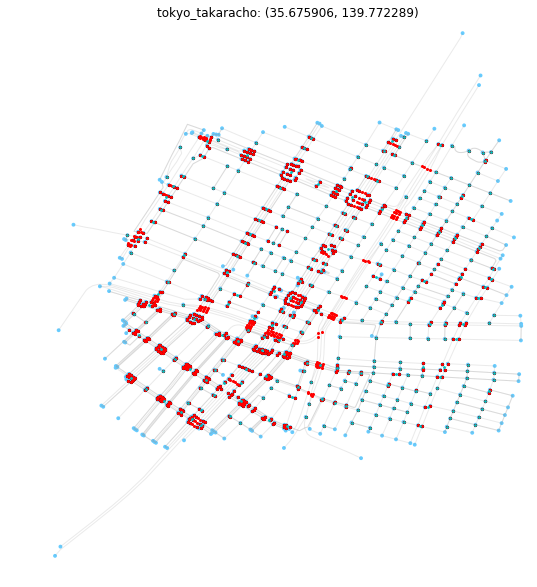

In [11]:
fig, ax = ox.plot_graph(G, fig_height=10, edge_alpha=0.2, node_alpha=None, close=True, show=False)

# show the true intersections in black
xs = nonplanar_intersections.map(lambda pt: pt.x)
ys = nonplanar_intersections.map(lambda pt: pt.y)
ax.scatter(xs, ys, c='k', s=5, zorder=2)

# plot the line split points in red to show false intersections
xs = planar_intersections.map(lambda pt: pt.x)
ys = planar_intersections.map(lambda pt: pt.y)
ax.scatter(xs, ys, c='r', s=4, zorder=3)

# plot consolidated intersections in cyan
xs = cleaned_intersections.map(lambda pt: pt.x)
ys = cleaned_intersections.map(lambda pt: pt.y)
ax.scatter(xs, ys, c='c', s=3, zorder=4)

ax.set_title('{}: {}'.format(name, coords))
fig.canvas.draw()
fig

In [12]:
ox.save_graph_shapefile(G, filename='graph', folder='data')

In [13]:
planar_intersections.to_file('data/graph/planar')
nonplanar_intersections.to_file('data/graph/nonplanar')
cleaned_intersections.to_file('data/graph/cleaned')

In [14]:
north, south, east, west = ox.bbox_from_point(coords, distance)
polygon = Polygon([(west, north), (west, south), (east, south), (east, north)])
gpd.GeoSeries([polygon]).to_file('data/graph/bbox')